# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Необходимо построить модель с максимально большим значением accuracy. Целевое значение метрики должно быть больше или равно 0.75.

## Загрузка данных

In [1]:
# Импортируем pandas и необходимые для работы модели и методы из библиотеки scikit-learn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
# Прочитаем наш датасет
df = pd.read_csv('/datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Подготовим выборки

Разделим датасет на обучающию, валидационную и тестовую выборки с соотношением 0.6/0.2/0.2.

In [3]:
# Разделим датасет на выборки и выведем некоторые из них на экран для наглядности
# Сначала разделим на обучающию и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=987654321)

# Теперь из обучающей выборки выделим валидационную выборку
# Размер валидационной выборки указан как 0.25, потому что 0.25 * 0.8 = 0.2 (0.8 - размер обучающей выборки)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=987654321)

features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

display(features_train)
target_train.head(5)

,calls,minutes,messages,mb_used
2140,74.0,546.21,35.0,20134.43
364,45.0,358.33,36.0,15723.08
237,56.0,469.49,145.0,15877.65
3057,59.0,381.49,47.0,17272.81
651,18.0,147.93,18.0,1904.01
...,...,...,...,...
709,77.0,571.62,7.0,17096.14
655,99.0,688.70,16.0,18758.43
2256,0.0,0.00,42.0,13280.45
195,125.0,874.85,22.0,20647.82


2140    0
364     1
237     1
3057    0
651     1
Name: is_ultra, dtype: int64

## Исследуем модели

### Дерево решений 

Найдём наилучшую модель дерева решений. В цикле будем проверять глубину дерева от 1 до 10. Сохраним модель с наибольшей долей правильных ответов (`accuracy_score`).

In [4]:
# Найдём наиболее точную модель на основе дерева решений
best_model_dt = None
best_result_dt = 0
best_result_dt_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=987654321, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_dt:
        best_model_dt = model
        best_result_dt = result
        best_result_dt_depth = depth
        
f'Accuracy лучшей модели на валидационной выборке: {best_result_dt} c глубиной {best_result_dt_depth}'

'Accuracy лучшей модели на валидационной выборке: 0.7947122861586314 c глубиной 3'

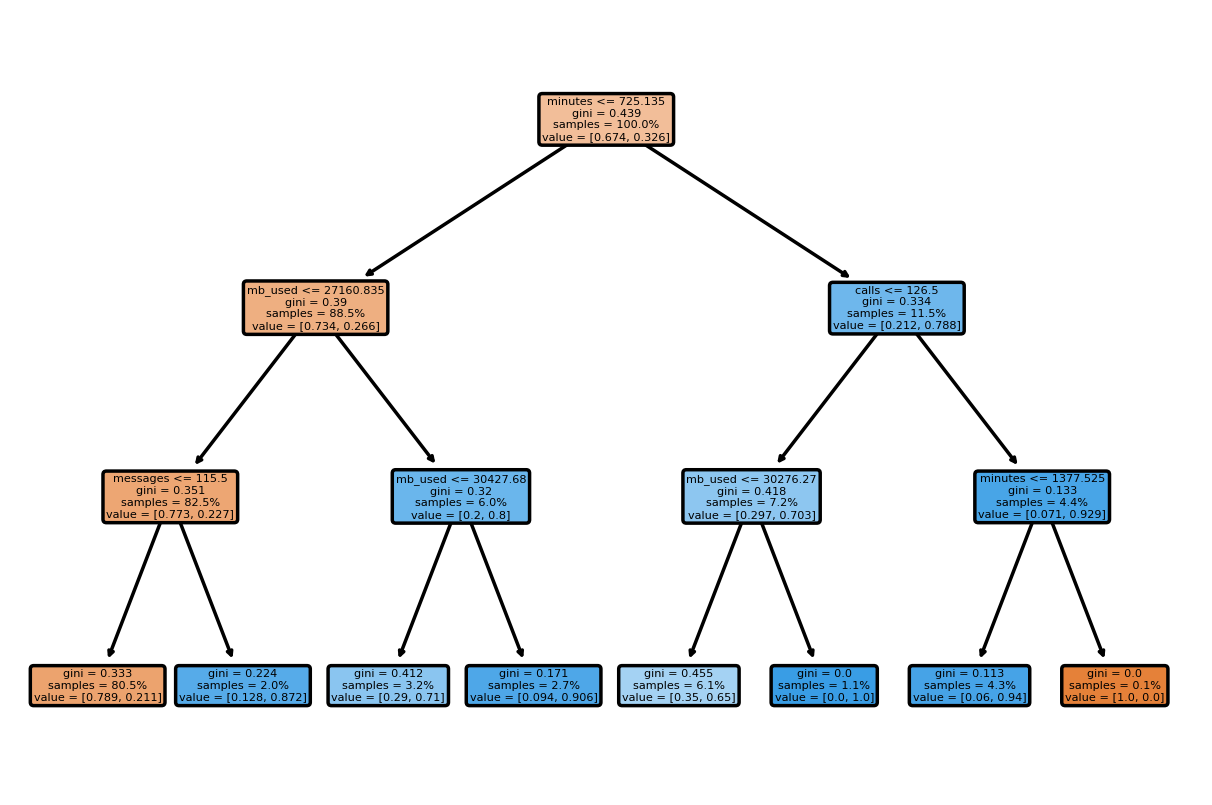

In [5]:
# Для наглядности посмотрим на наилучшее дерево решений
plt.figure(dpi=250)
tree.plot_tree(
    best_model_dt,
    feature_names=['calls', 'minutes', 'messages', 'mb_used'], 
    filled=True, 
    proportion=True, 
    rounded=True
);

Теперь попробуем перебрать гиперпараметры `min_samples_split` и `min_samples_leaf` и посмотреть на результат.

In [6]:
best_model_dt = None
best_result_dt = 0
best_result_dt_depth = 0
for i in range(2, 20):
    model = DecisionTreeClassifier(random_state=987654321, max_depth=3, min_samples_split=i)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_dt:
        best_model_dt = model
        best_result_dt = result
        best_result_dt_i = i
        
f'Accuracy лучшей модели на валидационной выборке: {best_result_dt} c min_samples_split={best_result_dt_i}'

'Accuracy лучшей модели на валидационной выборке: 0.7947122861586314 c min_samples_split=2'

В диапазоне 2-20 изменения гиперпараметра min_samples_split не принесло результатов. Наилучшее значение метрики accuracy была получено со значением по умолчанию, равным 2. Данная модель по accuracy равна модели без указания гиперпараметра min_samples_split.

Теперь попробуем изменить гиперпараметр min_samples_leaf. По умолчанию он принимает значение 1.

In [7]:
best_model_dt = None
best_result_dt = 0
best_result_dt_depth = 0
for i in range(1, 20):
    model = DecisionTreeClassifier(random_state=987654321, max_depth=3, min_samples_leaf=i)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_dt:
        best_model_dt = model
        best_result_dt = result
        best_result_dt_i = i
        
f'Accuracy лучшей модели на валидационной выборке: {best_result_dt} c min_samples_leaf={best_result_dt_i}'

'Accuracy лучшей модели на валидационной выборке: 0.7962674961119751 c min_samples_leaf=2'

Удалось немного улучшить модель. Accuracy повысилась на 0,15% со значением min_samples_leaf=2.

### Случайный лес

In [8]:
# Найдём наиболее точную модель на основе случайного леса
best_model_rf = None
best_result_rf = 0
best_result_rf_est = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=987654321, n_estimators=est)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_rf:
        best_model_rf = model
        best_result_rf = result
        best_result_rf_est = est

f'Accuracy лучшей модели на валидационной выборке: {best_result_rf} c количеством деревьев {best_result_rf_est}'

'Accuracy лучшей модели на валидационной выборке: 0.7744945567651633 c количеством деревьев 2'

Accuracy модели на основе случайного леса равна 77,45%. Количество деревьев - 2.

Попробуем теперь найти наилучшую модель на основе случайного леса с использованием значений гиперпараметров, которые мы нашли для единичного дерева решений.

In [9]:
# Найдём наиболее точную модель на основе случайного леса с гиперпараметрами от единичного дерева решений
best_model_rf = None
best_result_rf = 0
best_result_rf_est = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=987654321, n_estimators=est, max_depth=3, min_samples_leaf=2)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_rf:
        best_model_rf = model
        best_result_rf = result
        best_result_rf_est = est

f'Accuracy лучшей модели на валидационной выборке: {best_result_rf} c количеством деревьев {best_result_rf_est}'

'Accuracy лучшей модели на валидационной выборке: 0.8009331259720062 c количеством деревьев 10'

Accuracy модели повысилась до 80,09%! Увеличим количество деревьев в цикле.

In [10]:
# Найдём наиболее точную модель на основе случайного леса с гиперпараметрами от единичного дерева решений
# Укажем максимальное количество деревьев, равное 50
best_model_rf = None
best_result_rf = 0
best_result_rf_est = 0
for est in range(1, 51):
    model = RandomForestClassifier(random_state=987654321, n_estimators=est, max_depth=3, min_samples_leaf=2)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result_rf:
        best_model_rf = model
        best_result_rf = result
        best_result_rf_est = est

f'Accuracy лучшей модели на валидационной выборке: {best_result_rf} c количеством деревьев {best_result_rf_est}'

'Accuracy лучшей модели на валидационной выборке: 0.8009331259720062 c количеством деревьев 10'

Результат остался прежним - 80% при 10 деревьях. Уже ощущается увеличение времени расчёта при таком количестве деревьев в цикле поиска.

###  Логистическая регрессия

In [11]:
# Обучим модель на основе логистической регрессии
# По умолчанию используется алгоритм ‘lbfgs’ и максимальное количество итераций, равное 100 (по умолчанию)
model_lr = LogisticRegression(random_state=987654321)
model_lr.fit(features_train, target_train)
score_lr = model_lr.score(features_valid, target_valid)

f'Accuracy модели на валидационной выборке: {score_lr}'

'Accuracy модели на валидационной выборке: 0.7418351477449455'

Accuracy модели равна 74,18%. Попробуем несколько других алгоритмов с тем же количеством итераций.

In [12]:
# Обучим модель на основе логистической регрессии
# Используем алгоритм ‘liblinear’
model_lr = LogisticRegression(random_state=987654321, solver='liblinear')
model_lr.fit(features_train, target_train)
score_lr = model_lr.score(features_valid, target_valid)

f'Accuracy модели на валидационной выборке: {score_lr}'

'Accuracy модели на валидационной выборке: 0.7418351477449455'

Accuracy модели на алгоритме 'liblinear' равна точности модели на алгоритме 'lbfgs'.

In [13]:
# Обучим модель на основе логистической регрессии
# Используем алгоритм ‘newton-cg’
model_lr = LogisticRegression(random_state=987654321, solver='newton-cg')
model_lr.fit(features_train, target_train)
score_lr = model_lr.score(features_valid, target_valid)

f'Accuracy модели на валидационной выборке: {score_lr}'

'Accuracy модели на валидационной выборке: 0.7636080870917574'

В случае алгоритма 'newton-cg' accuracy модели немного улучшилась - до 76,36%. Но это всё равно меньше, чем accuracy модели на основе случайного леса.

### Выводы по исследованиям моделей 

В результате исследований моделей были получены следующие результаты:
1. Дерево решений, accuracy - 79,47%.
2. Случайный лес, accuracy - 80,09%.
3. Логистическая регрессия, accuracy - 76,36%.

Лучший результат у модели на основе случайного леса с accuracy 80,09%.  
Для случайного леса использовались наилучшие гиперпараметры, которые были подобраны для единичного дерева решений. Итоговые параметры модели случайного леса: 
1. Количество деревьев - 10
2. Максимальная глубина дерева - 3
3. Минимальное количество объектов в листе - 2

## Проверка модели на тестовой выборке

In [14]:
# Проверим точность нашей наилучшей модели на тестовой выборке
score = best_model_rf.score(features_test, target_test)
f'Accuracy модели на тестовой выборке: {score}'

'Accuracy модели на тестовой выборке: 0.8118195956454122'

Accuracy модели на тестовой выборке оказалась чуть выше, чем на валидационной - 81,18%.

## Проверка модели на адекватность

Для проверки модели на адекватность сравним полученное значение метрики accuracy со случайной выборкой. В нашем случае мы имеем биномиальное распределение, т.к. результат у нас может быть равен либо 0 (пользователю рекомендован тариф "Смарт"), либо 1 (пользователю рекомендован тариф "Ультра"). Таким образом точность случайной выборки будет равна 50%.

Аccuracy нашей модели равна 81,18%. 81,18% > 50%. Таким образом считаем нашу модель адекватной.